In [2]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_auc_score, r2_score
from lifelines.utils import concordance_index as c_index

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

defining feature and target matrix

In [3]:
data = pd.read_csv('test_scores.csv')
X = data.drop(columns=['posttest'])
y = data['posttest']

Defining column transformation

In [4]:
ct_data = ColumnTransformer([
    ('school', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['school'] ), #we could also think to join school and classroom
    ('school_type', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['school_type']),
    ('school_setting', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['school_setting']),
    ('teaching_method', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['teaching_method']),
    ('classroom', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['classroom']),
    ('n_student', StandardScaler(), ['n_student']),
    ('gender', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['gender']),
    ('lunch', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ['lunch']),
    ('pretest', StandardScaler(), ['pretest'])
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0
    )

Train Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)

In [6]:
X_train_etl = ct_data.fit_transform(X_train)
X_train_etl

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.26302497],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         1.        , -1.11848641],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.22111374],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.3699582 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.44868633],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.26302497]])

In [7]:
X_test_etl = ct_data.transform(X_test)

In [8]:
f'The transformed training dataset has {X_train_etl.shape[1]} features, and the transformed test set has {X_test_etl.shape[1]}. That\'s good!'

"The transformed training dataset has 126 features, and the transformed test set has 126. That's good!"

In [9]:
sfs1 = SFS(Perceptron(), 
           k_features=20, 
           forward=True, 
           scoring='r2',
           cv = 0
        )
sfs1.fit(X_train_etl, y_train)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

SequentialFeatureSelector(cv=0, estimator=Perceptron(), k_features=(20, 20),
                          scoring='r2')

In [9]:
sfs2 = SFS(LogisticRegression(), 
           k_features=20, 
           forward=True, 
           scoring='r2',
           cv = 0
        )
sfs2.fit(X_train_etl, y_train)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(),
                          k_features=(20, 20), scoring='r2')

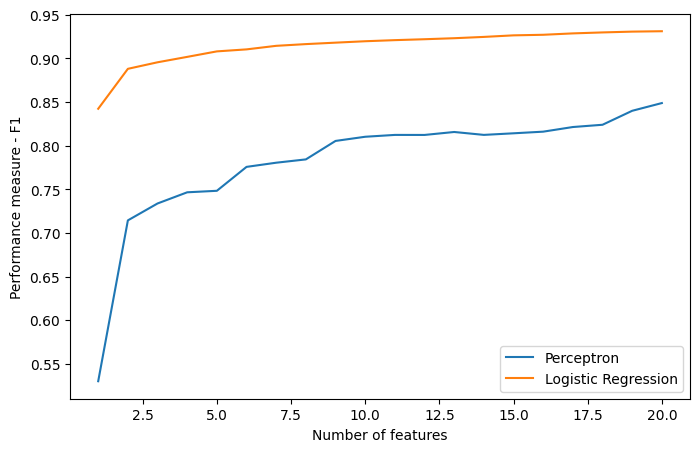

In [ ]:
scores_1 = sfs1.get_metric_dict()
scores_2 = sfs2.get_metric_dict()
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot()
ax.plot(list(scores_1.keys()),[v['avg_score'] for v in scores_1.values()], label = 'Perceptron')
ax.plot(list(scores_2.keys()),[v['avg_score'] for v in scores_2.values()], label = 'Logistic Regression')
ax.set_xlabel('Number of features')
ax.set_ylabel('Performance measure - R2')
ax.legend()

In [11]:
# Logistic Regression training on SFS forward
sfs2 = SFS(LogisticRegression(), 
           k_features=25, 
           forward=True, 
           scoring='r2',
           cv = 0
        )
X_train_red = sfs2.fit_transform(X_train_etl, y_train)
lr_cls = LogisticRegression()
lr_cls.fit(X_train_red,y_train)
predictions = lr_cls.predict(sfs2.transform(X_test_etl))


In [12]:
lr_score = r2_score(y_test, predictions)
print(f'R2-score on the test set for SFS + Logistic Regression: {lr_score:.4f}')

R2-score on the test set for SFS + Logistic Regression: 0.9221


In [ ]:
# Logistic Regression training on PCA
dim_red = PCA(n_components=25)  
lr_cls = LogisticRegression()
lr_cls.fit(dim_red.fit_transform(X_train_etl),y_train)
predictions = lr_cls.predict(dim_red.transform(X_test_etl))
lr_score = r2_score(y_test, predictions)
print(f'R2-score on the test set for PCA + Logistic Regression: {lr_score:.4f}')

F1-score on the test set for PCA + Logistic Regression: 0.8890


In [14]:
# Logistic Regression training on SFS forward
sfs2 = SFS(LogisticRegression(), 
           k_features=25, 
           forward=True, 
           scoring='r2',
           cv = 0
        )
X_train_red = sfs2.fit_transform(X_train_etl, y_train)
lr_cls = LogisticRegression()
lr_cls.fit(X_train_red,y_train)
predictions = lr_cls.predict(sfs2.transform(X_test_etl))
lr_score = r2_score(y_test, predictions)
print(f'R2-score on the test set for SFS + Logistic Regression: {lr_score:.4f}')

F1-score on the test set for SFS + Logistic Regression: 0.9221


In [15]:
## Logistic Regression training on PCA
dim_red = LDA()
lr_cls = LogisticRegression()
lr_cls.fit(dim_red.fit_transform(X_train_etl,y_train),y_train)
predictions = lr_cls.predict(dim_red.transform(X_test_etl))
lr_score = r2_score(y_test, predictions)
print(f'R2-score on the test set for LDA + Logistic Regression: {lr_score:.4f}')

R2-score on the test set for LDA + Logistic Regression: 0.9260


In [16]:
pipeline = Pipeline([
    ('etl', ct_data),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LogisticRegression())
])

In [17]:
pipeline.fit(X_train, y_train)
prediction_train = pipeline.predict(X_train)
prediction_test = pipeline.predict(X_test)
print(f'C-index training set: {c_index(y_train,prediction_train):.4f} - C-index test set: {c_index(y_test,prediction_test):.4f}')
print(f'R2 training set: {r2_score(y_train,prediction_train):.4f} - R2 test set: {r2_score(y_test,prediction_test):.4f}')

C-index training set: 0.9041 - C-index test set: 0.9004
R2 training set: 0.8908 - R2 test set: 0.8797


A value C index near to 1 tells us that the model do a great job in predicting, while a number near to 0.5 tells us that it doesn't perform better than a random picking

High r2 score and high concordance index tell us that our model fits well on true values and well preserves the ranking

In [29]:
scores = []
for column in X.columns:
    print(column)
    temp = X_test.drop(columns=str(column))
    pred = pipeline.predict(temp) #se togli una colonna ovviamente la pipeline originale non va bene
    scores.append(column, r2_score(y_test, pred))

print(scores)

school


ValueError: columns are missing: {'school'}